In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

FILE = '../data/carotene/data_random_pool.mat'
ENZYMES = ['E', 'I', 'YB']
TARGET = ['prod']

def data_to_df(file: str) -> pd.DataFrame:
    """ Load data from .mat file and convert to pandas DataFrame"""
    data = loadmat(file)
    df = pd.DataFrame(data['TrainingSet'], columns=ENZYMES + TARGET)
    df[ENZYMES] = df[ENZYMES].round(4)
    return df

def get_enzyme_levels(df: pd.DataFrame) -> list:
    """ Get all unique values in the columns in the list """
    unique_values = []
    for col in ENZYMES:
        unique_values += df[col].unique().tolist()
    return np.unique(unique_values)

def create_comb_space(df: pd.DataFrame) -> pd.DataFrame:
    """ Create a combination space for all unique values in the columns in the list """
    enzyme_levels = get_enzyme_levels(df)
    comb_space = pd.DataFrame(np.array(np.meshgrid(*[enzyme_levels]*3)).T.reshape(-1, 3), columns=ENZYMES)
    return comb_space

def linlog_transformation(df: pd.DataFrame, columns: list) -> pd.DataFrame:
    """ Perform linlog transformation on the columns in the list """
    log_data = np.log10(df[columns])
    scaled_data = 2 * (log_data - log_data.min()) / (log_data.max() - log_data.min()) - 1
    return scaled_data

def target_normalization(df: pd.DataFrame, target: str, SCALE: float = 0.7) -> pd.DataFrame:
    """ Normalize the target column """
    df[target] = (df[target] - df[target].min()) / (df[target].max() - df[target].min())
    df[target] = df[target] * SCALE
    return df

In [2]:
df = data_to_df(FILE)
comb_space = create_comb_space(df)

ENZYME_LEVELS = get_enzyme_levels(df)
print(f'Number of unique enzyme levels: {len(ENZYME_LEVELS)}')

df_scaled = linlog_transformation(df, ENZYMES).round(2)
comb_space_scaled = linlog_transformation(comb_space, ENZYMES).round(2)

df = target_normalization(df, 'prod')

# From comb_space_scaled remove rows that are in df_scaled
comb_space_scaled = comb_space_scaled[~comb_space_scaled.isin(df_scaled)].dropna()

Number of unique enzyme levels: 10


In [3]:
# Get X_train, y_train and X_test
X_train = df_scaled[ENZYMES].values
y_train = df[TARGET].values.ravel()

X_test = comb_space_scaled[ENZYMES].values

**Machine Learning Modeling**

In [4]:
import tensorflow as tf  
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense

# Create the ANN model
nn = Sequential()
nn.add(Dense(2, input_dim=X_train.shape[1], activation='sigmoid'))
nn.add(Dense(1, activation='linear'))

# Compile the model
optimizer = keras.optimizers.Adam(learning_rate=0.01)
nn.compile(loss='mean_squared_error', optimizer=optimizer)

# Train the model
history = nn.fit(X_train, y_train, epochs=1000, validation_split=0.1, verbose=1)


2024-06-20 12:14:03.969301: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-20 12:14:03.972819: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-20 12:14:04.009895: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-20 12:14:04.009929: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-20 12:14:04.009967: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

Epoch 1/1000
1/1 [==============================] - 1s 729ms/step - loss: 0.0999 - val_loss: 0.0908
Epoch 2/1000
1/1 [==============================] - 0s 36ms/step - loss: 0.0870 - val_loss: 0.0744
Epoch 3/1000
1/1 [==============================] - 0s 39ms/step - loss: 0.0754 - val_loss: 0.0599
Epoch 4/1000
1/1 [==============================] - 0s 35ms/step - loss: 0.0653 - val_loss: 0.0473
Epoch 5/1000
1/1 [==============================] - 0s 38ms/step - loss: 0.0565 - val_loss: 0.0366
Epoch 6/1000
1/1 [==============================] - 0s 35ms/step - loss: 0.0492 - val_loss: 0.0278
Epoch 7/1000
1/1 [==============================] - 0s 36ms/step - loss: 0.0432 - val_loss: 0.0209
Epoch 8/1000
1/1 [==============================] - 0s 37ms/step - loss: 0.0385 - val_loss: 0.0156
Epoch 9/1000
1/1 [==============================] - 0s 33ms/step - loss: 0.0350 - val_loss: 0.0118
Epoch 10/1000
1/1 [==============================] - 0s 33ms/step - loss: 0.0326 - val_loss: 0.0093
Epoch 11

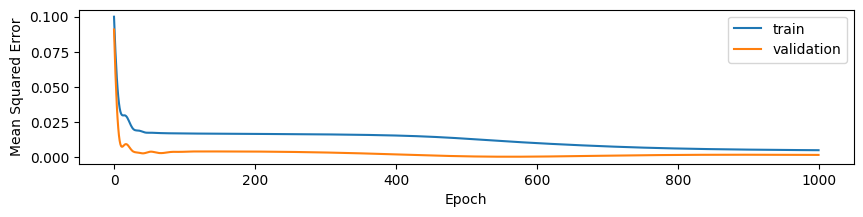

In [8]:
# Plot the training history
plt.figure(figsize=(10, 2))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

In [22]:
comb_space_scaled['prod'] = nn.predict(X_test)
comb_space_scaled.sort_values(by='prod', ascending=False).head(25)

32/32 [==============================] - 0s 1ms/step


,E,I,YB,prod
999,1.00,1.00,1.00,0.774492
998,1.00,0.89,1.00,0.757828
989,0.89,1.00,1.00,0.744669
899,1.00,1.00,0.89,0.738290
988,0.89,0.89,1.00,0.726005
997,1.00,0.68,1.00,0.723666
898,1.00,0.89,0.89,0.719428
889,0.89,1.00,0.89,0.703295
987,0.89,0.68,1.00,0.688058
888,0.89,0.89,0.89,0.682486


In [19]:
# import shap

# # Create an explainer
# explainer = shap.KernelExplainer(nn.predict, X_train)

# # Calculate SHAP values
# shap_values = explainer.shap_values(X_train)

# # Plot the SHAP values
# shap.summary_plot(shap_values[0], X_train, feature_names=ENZYMES, plot_type='dot')

In [20]:
# # Local interpretation
# idx = 13
# shap.force_plot(explainer.expected_value[0], shap_values[0][idx], X_train[idx], feature_names=ENZYMES)

In [7]:
# # import the necessary packages
# from omlt import OmltBlock, OffsetScaling
# from omlt.io.keras import load_keras_sequential
# from omlt.neuralnet import FullSpaceSmoothNNFormulation
# import pyomo.environ as pyo

# nn.save('reformer_nn.keras')

# # first, create the Pyomo model
# m = pyo.ConcreteModel()
# m.reformer = OmltBlock()

# nn_reformer = keras.models.load_model('reformer_nn.keras', compile=False)
# net = load_keras_sequential(nn_reformer)

# # create the variables and constraints for the neural network in Pyomo
# m.reformer.build_formulation(FullSpaceSmoothNNFormulation(net))

# solver = pyo.SolverFactory('glpk')
# status = solver.solve(m, tee=True)